In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, Conv2DTranspose, BatchNormalization, LeakyReLU, UpSampling2D
from tensorflow.keras import layers, losses
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

from utils.image_formatting import *

%load_ext autoreload
%autoreload 2

n=128

In [2]:
X, y = preprocess_images2(artists=list(PAINTER_DICT.keys()), n_imgs=1000, dropout_rate=None)
X_aug = np.flip(X, axis=2)
y_aug = y
X = np.concatenate((X, X_aug), axis=0)
y = np.concatenate((y, y_aug), axis=0)
X_train, X_val, _ , _ = train_test_split(X, y, test_size=0.1)   

print(X_train.shape)
print(X_val.shape)

(7207, 128, 128, 3)
(801, 128, 128, 3)


In [3]:
# accuracy reach 72%
CAE = Sequential()
CAE.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), 
               activation='relu', 
               input_shape=(n, n, 3), 
               padding='same', name = 'Conv2D_1'))
CAE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='MaxPool_1'))

CAE.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1,1), 
               activation='relu', 
               padding='same', 
               name='Conv2D_2'))
CAE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='MaxPool_2'))

CAE.add(Conv2D(filters=128, kernel_size=(5, 5), strides=(1,1), 
               activation='relu', 
               padding='same', 
               name='Conv2D_3'))
CAE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='MaxPool_3'))

CAE.add(UpSampling2D(interpolation='bilinear', name='UpSample_1'))
CAE.add(Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', name='DeConv2D_1'))

CAE.add(UpSampling2D(interpolation='bilinear', name='UpSample_2'))
CAE.add(Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', name='De2DTrans_2'))

CAE.add(UpSampling2D(interpolation='bilinear', name='UpSample_3'))
CAE.add(Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', name='De2DTrans_3'))

CAE.add(Conv2DTranspose(filters=3, kernel_size=(1, 1), strides=(1, 1), activation='relu', name='Conv2DTrans_recon'))
CAE.summary()
CAE.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
            loss=keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.Accuracy())        # compile model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 64, 64, 32)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 32, 32, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
MaxPool_3 (MaxPooling2D)     (None, 16, 16, 128)       0         
_________________________________________________________________
UpSample_1 (UpSampling2D)    (None, 32, 32, 128)       0

In [4]:
# Train CAE (Unsupervised Training)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta = 2, 
                                            mode = 'min', 
                                            patience=3)
CAE_train_history = CAE.fit(x=X_train, y=X_train, 
                            batch_size=32, 
                            epochs=30, 
                            validation_data=(X_val, X_val),
                            callbacks=[callback])

Epoch 1/30
226/226 [==============================] - 25s 89ms/step - loss: 9129.7726 - accuracy: 0.0068 - val_loss: 6388.9575 - val_accuracy: 0.0094
Epoch 2/30
226/226 [==============================] - 19s 83ms/step - loss: 6270.5277 - accuracy: 0.0125 - val_loss: 694.5040 - val_accuracy: 0.0108
Epoch 3/30
226/226 [==============================] - 19s 83ms/step - loss: 637.1773 - accuracy: 0.0129 - val_loss: 509.1270 - val_accuracy: 0.0127
Epoch 4/30
226/226 [==============================] - 19s 84ms/step - loss: 499.2637 - accuracy: 0.0147 - val_loss: 471.4909 - val_accuracy: 0.0139
Epoch 5/30
226/226 [==============================] - 19s 84ms/step - loss: 458.6540 - accuracy: 0.0169 - val_loss: 424.2541 - val_accuracy: 0.0140
Epoch 6/30
226/226 [==============================] - 19s 84ms/step - loss: 425.4945 - accuracy: 0.0171 - val_loss: 421.9740 - val_accuracy: 0.0143
Epoch 7/30
226/226 [==============================] - 19s 84ms/step - loss: 407.6807 - accuracy: 0.0158 - val

In [5]:
# # Save model
# CAE_path = "models/cae"
# CAE.save(CAE_path)

In [6]:
# from tensorflow import keras
# CAE = keras.models.load_model('models/cae')

# Visualize encoded resuslts

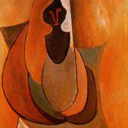

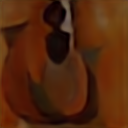

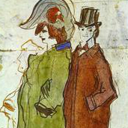

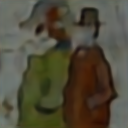

In [7]:
# show the output of reconstruction
from PIL import Image
import numpy as np

for i in range(2):
    original_image = Image.fromarray(X[i])
#     original_image_path = 'comparison/original_image.png'
#     original_image.save(original_image_path)
    expand = np.expand_dims(X[i], 0)
    reconstruct_output = CAE(expand).numpy().reshape((n, n, 3))
    output_max = np.max(reconstruct_output)
    output_min = np.min(reconstruct_output)
    reconstruct_output = (reconstruct_output - output_min) / (output_max - output_min) * (n-1)
    reconstruct_output = reconstruct_output.astype(np.uint8)
    reconstruct_image = Image.fromarray(reconstruct_output)
#     reconstruct_image_path = 'comparison/reconstruct_image.png'
#     reconstruct_image.save(reconstruct_image_path)
    
    original_image.show()
    reconstruct_image.show()

# Train Fully Connected Layers

In [8]:
# Use the hyperparameter learned from CAE and classify the paints
# artists = ['pierre-auguste-renoir', 'vincent-van-gogh', 'pablo-picasso']
artists = ['rembrandt', 'pierre-auguste-renoir', 'vincent-van-gogh']
# artists=list(PAINTER_DICT.keys())

X, y = preprocess_images2(artists=artists, n_imgs=1000, dropout_rate=0)
X_aug = np.flip(X, axis=2)
y_aug = y
X = np.concatenate((X, X_aug), axis=0)
y = np.concatenate((y, y_aug), axis=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2565, 128, 128, 3) (2565,)
(285, 128, 128, 3) (285,)


In [88]:
cae_output = Model(inputs = CAE.input, outputs = CAE.layers[-6].output, name = 'cae_output')
for layer in cae_output.layers:
    layer.trainable = False
following_layers = Sequential()
input_shape = (cae_output.output.shape[1], cae_output.output.shape[2], cae_output.output.shape[3])
following_layers.add(tf.keras.layers.Input(shape=input_shape))
following_layers.add(Flatten(name = 'flatten'))
following_layers.add(Dropout(0.1, name = "Dropout_1"))
following_layers.add(Dense(256, 
#                            activation = 'relu', 
                           kernel_regularizer = 'l2', 
#                            bias_regularizer = 'l2', 
                           name = "Dense_1"))
# following_layers.add(BatchNormalization())
following_layers.add(LeakyReLU(0.1))

following_layers.add(Dense(128, 
#                            activation = 'relu', 
                           kernel_regularizer = 'l2', 
#                            bias_regularizer = 'l2', 
                           name = "Dense_2"))
# following_layers.add(BatchNormalization())
following_layers.add(LeakyReLU(0.1))

following_layers.add(Dense(64, 
#                            activation = 'relu', 
                           kernel_regularizer = 'l2', 
#                            bias_regularizer = 'l2', 
                           name = "Dense_3"))
# following_layers.add(BatchNormalization())
following_layers.add(LeakyReLU(0.1))


following_layers.add(Dense(3, activation = 'softmax', name = "softmax"))
painter_classifier = Model(inputs = cae_output.inputs, outputs = following_layers(cae_output.output))
painter_classifier.summary()
painter_classifier.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                           loss = 'sparse_categorical_crossentropy', 
                           metrics = ['accuracy'])


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1_input (InputLayer)  [(None, 128, 128, 3)]     0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 64, 64, 32)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 32, 32, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
MaxPool_3 (MaxPooling2D)     (None, 16, 16, 128)       0   

In [89]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            min_delta = 0.005, 
                                            mode = 'max', 
                                            patience=5)
cae_training_history = painter_classifier.fit(x=X_train, y=y_train, 
                                              batch_size=32, epochs=30, 
                                              validation_data=(X_val, y_val),
                                              callbacks = [callback])

Epoch 1/30
81/81 [==============================] - 3s 27ms/step - loss: 259.3101 - accuracy: 0.4173 - val_loss: 98.7724 - val_accuracy: 0.4912
Epoch 2/30
81/81 [==============================] - 2s 24ms/step - loss: 45.0101 - accuracy: 0.6385 - val_loss: 48.8652 - val_accuracy: 0.5474
Epoch 3/30
81/81 [==============================] - 2s 24ms/step - loss: 20.8782 - accuracy: 0.7546 - val_loss: 70.6899 - val_accuracy: 0.4456
Epoch 4/30
81/81 [==============================] - 2s 24ms/step - loss: 27.0356 - accuracy: 0.7029 - val_loss: 17.3921 - val_accuracy: 0.7649
Epoch 5/30
81/81 [==============================] - 2s 24ms/step - loss: 22.2340 - accuracy: 0.7186 - val_loss: 15.5714 - val_accuracy: 0.8035
Epoch 6/30
81/81 [==============================] - 2s 27ms/step - loss: 12.3800 - accuracy: 0.8177 - val_loss: 11.8607 - val_accuracy: 0.7789
Epoch 7/30
81/81 [==============================] - 2s 24ms/step - loss: 10.8407 - accuracy: 0.8211 - val_loss: 13.0956 - val_accuracy: 0.747

# Testing

In [90]:
# artists = ['rembrandt', 'pierre-auguste-renoir', 'vincent-van-gogh']

X_true, y_true = preprocess_images2(artists=artists, n_imgs=25, test_set=True)

print(X_true.shape, y_true.shape)

(75, 128, 128, 3) (75,)


In [91]:
y_pred = painter_classifier.predict(X_true)
y_pred = np.argmax(y_pred, axis = 1)

In [92]:
y_pred

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0,
       1, 2, 1, 1, 2, 2, 0, 0, 0])

In [93]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [94]:
confusion_matrix(y_true, y_pred)

array([[21,  4,  0],
       [ 0, 22,  3],
       [ 6,  3, 16]])

In [95]:
accuracy_score(y_true, y_pred)

0.7866666666666666